In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.spatial.distance import cdist


import ipywidgets as widgets
from IPython import display
import imageio

from itertools import combinations

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
#pip install --upgrade --force-reinstall git+https://github.com/glendawur/MirCl.git

----

# Data Generation

In [4]:
from mircl.generation import generate_blobs_set, generate_sphere

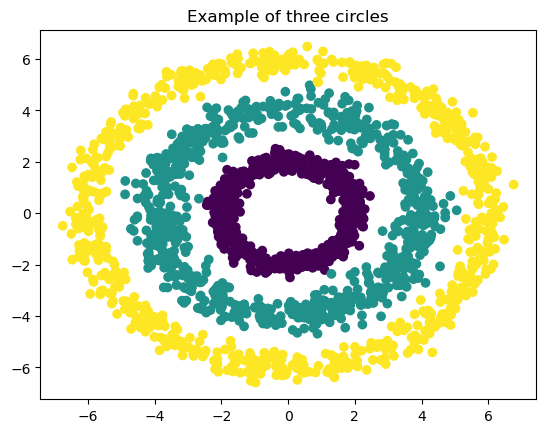

CPU times: user 72 ms, sys: 11.5 ms, total: 83.5 ms
Wall time: 88.9 ms


In [5]:
%%time
data = [(generate_sphere(n_samples=size,
                         n_features=2,
                         radius=2*(k+1),
                         noise=np.random.choice([0.05, 0.075, 0.1], 1)),
        np.full((size, ), k)) for (k, size) in zip(range(3), np.random.randint(500, 1000, 3))]
x, y = np.concatenate([x[0] for x in data]), np.concatenate([y[1] for y in data]) 

plt.scatter(x[:,0], x[:,1], c= y)
plt.title('Example of three circles')
plt.show()

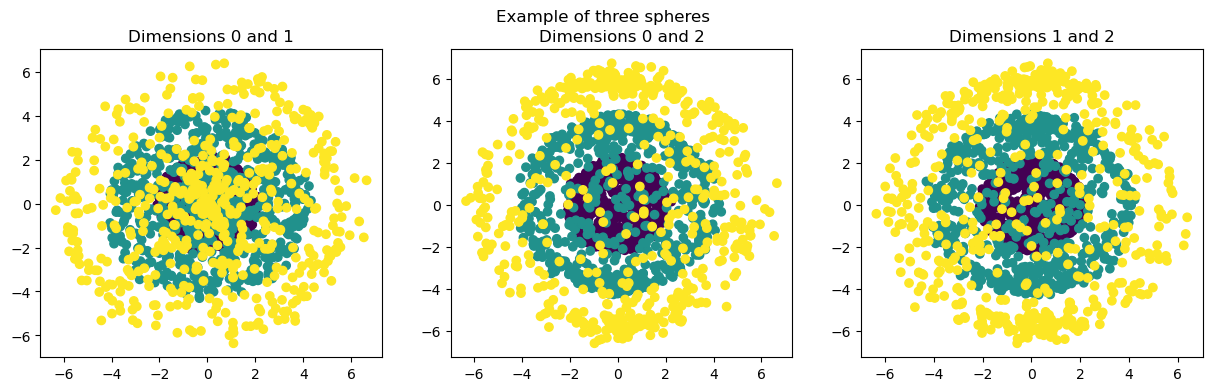

CPU times: user 202 ms, sys: 1.76 ms, total: 204 ms
Wall time: 204 ms


In [6]:
%%time

data = [(generate_sphere(n_samples=size,
                         n_features=3,
                         radius=2*(k+1),
                         noise = 0.05),
        np.full((size, ), k)) for (k, size) in zip(range(3), np.random.randint(500, 1000, 3))]
x, y = np.concatenate([x[0] for x in data]), np.concatenate([y[1] for y in data]) 

fig, ax = plt.subplots(1, 3, figsize = (15, 4))
for p, (i,j) in enumerate(list(combinations(np.arange(0, 3), 2))):
    ax[p].scatter(x[:,i], x[:,j], c=y)
    ax[p].set_title(f'Dimensions {i} and {j}')
fig.suptitle('Example of three spheres')
plt.show()

------

In [7]:
%time x, y, meta = generate_blobs_set(N = 2000, k=5, M = 3, a=0.75, n=60, meta=True)

CPU times: user 1.11 ms, sys: 0 ns, total: 1.11 ms
Wall time: 1.13 ms


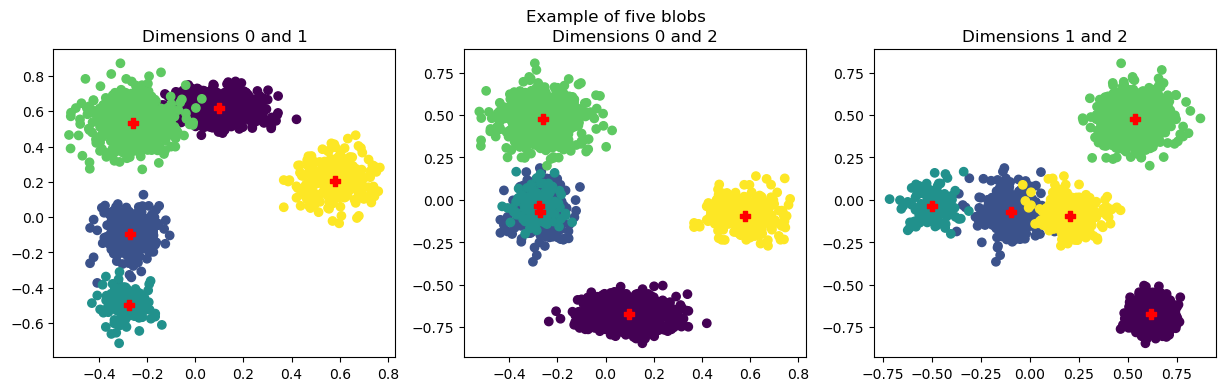

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
for p, (i,j) in enumerate(list(combinations(np.arange(0, 3), 2))):
    ax[p].scatter(x[:,i], x[:,j], c=y)
    ax[p].set_title(f'Dimensions {i} and {j}')

    for cluster in list(meta.keys())[-5:]:
        ax[p].scatter(meta[cluster]['center'][i], meta[cluster]['center'][j], marker='P', c = 'red', s=50)
    
fig.suptitle('Example of five blobs')
plt.show()

------

# Clustering

### K-Means algorithm

In [9]:
from mircl.clustering import Kmeans, RandomSwap, AnomalousPatterns

In [10]:
km = Kmeans(x)

In [11]:
%%time
labels, centers = km.fit(k=5, 
                         init_centers=None, 
                         init_method='kmeans++', 
                         max_iter=60)

CPU times: user 2.95 ms, sys: 323 µs, total: 3.27 ms
Wall time: 3.06 ms


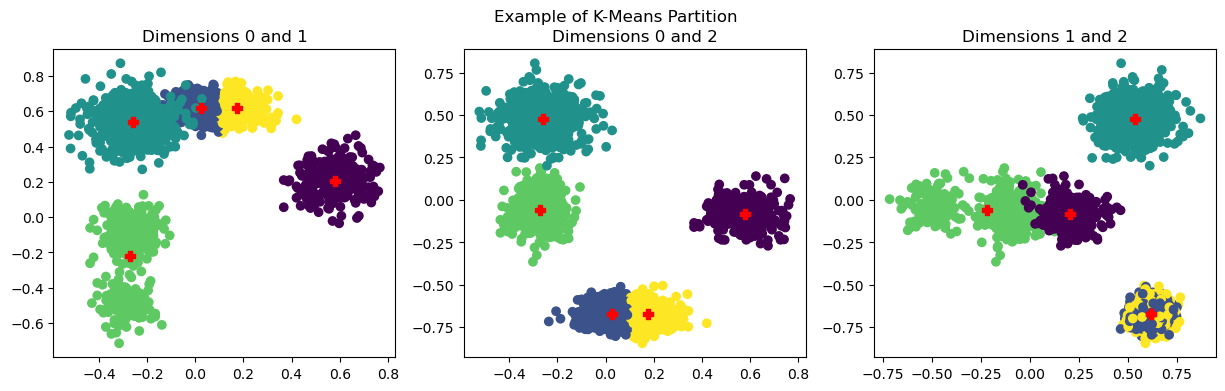

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
for p, (i,j) in enumerate(list(combinations(np.arange(0, 3), 2))):
    ax[p].scatter(x[:,i], x[:,j], c=labels)
    ax[p].set_title(f'Dimensions {i} and {j}')
    
    ax[p].scatter(centers[:, i], centers[:, j], marker='P', c = 'red', s=50)
    
fig.suptitle('Example of K-Means Partition')
plt.show()

-----

History of the partition lookup on more hard-to-discriminate example

In [13]:
%time hard_x, hard_y, meta = generate_blobs_set(N = 2000, k=7, M = 2, a=0.6, n=60, meta=True)
hard_km = Kmeans(data = hard_x)
_, _ = hard_km.fit(k=7, 
                             init_centers=None, 
                             init_method='maxmin', 
                             max_iter=60)
true_centers = np.array([meta[p]['center'] for p in list(meta.keys())[-7:]])

CPU times: user 1.96 ms, sys: 192 µs, total: 2.15 ms
Wall time: 2.24 ms


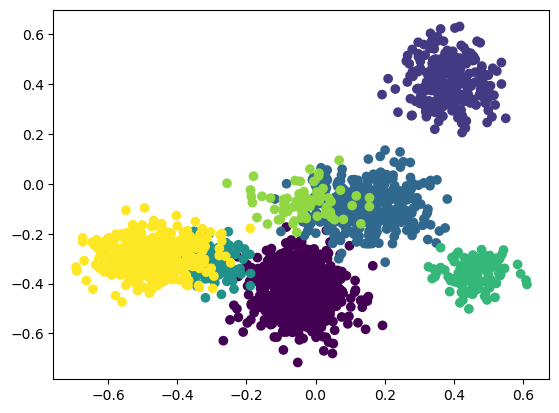

In [14]:
plt.scatter(hard_x[:,0], hard_x[:,1], c=hard_y)
plt.show()

In [15]:
km_example = 'pics\km_example.gif'

filenames = list()

for i in range(len(hard_km.last_call_history)):
    c = hard_km.last_call_history[i]
    ls = cdist(hard_x, c).argmin(axis = 1)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))
    plt.scatter(hard_x[:,0], hard_x[:,1], c=ls)
    plt.scatter(c[:,0], c[:,1], c='red', s = 60, marker='P')
    plt.scatter(true_centers[:,0], true_centers[:,1], s = 70, marker='o', facecolors='none', edgecolors='r')
    fig.suptitle(f'Iteration {i}')
    filename = f'km_ex_{i}.png'
    filenames.append(filename)
    plt.savefig(filename, dpi=100)
    plt.close()
    
with imageio.get_writer(km_example, mode='I', duration=10/len(hard_km.last_call_history)) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_406/229572975.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


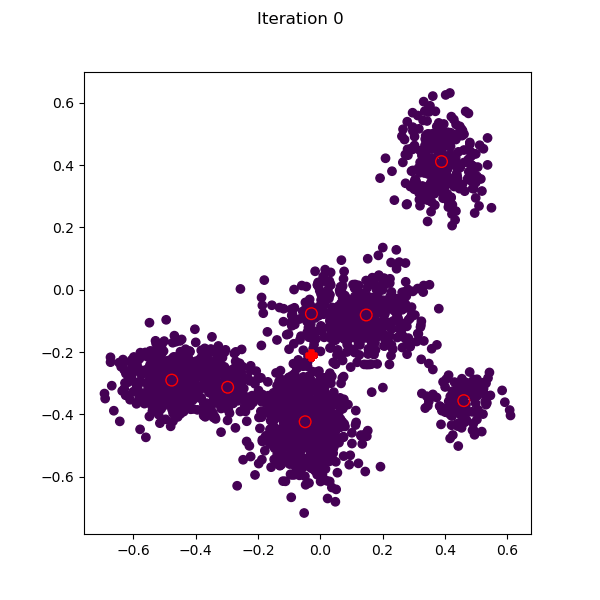

In [16]:
display.Image(km_example)

<img src="pics/km_example.gif" width="750" align="center">

------

#### Centers Initialization

In [17]:
from mircl.miscellaneous import centering

In [18]:
%time x_test, y_test = generate_blobs_set(N = 1000, k=3, M = 2, a=0.75, n=60, meta=False)

CPU times: user 976 µs, sys: 53 µs, total: 1.03 ms
Wall time: 845 µs


In [19]:
km_test = Kmeans(x_test)
c_plus = km_test.init_centers(k=3, method='kmeans++')
c_maximin = km_test.init_centers(k=3, method='maxmin')
c_random = km_test.init_centers(k =3, method='random')

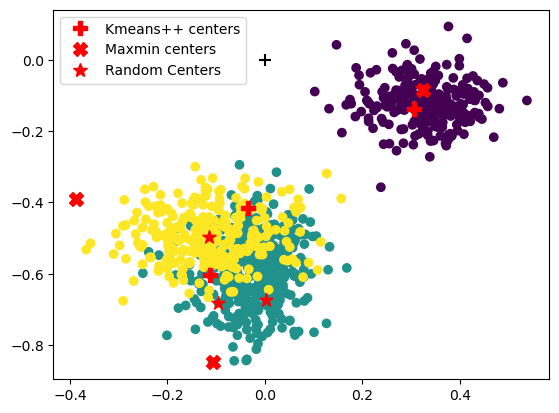

In [20]:
plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plt.scatter(c_plus[:,0], c_plus[:,1], c='red', marker='P', s = 100)
plt.scatter(c_maximin[:,0], c_maximin[:,1], c='red', marker='X', s=100)
plt.scatter(c_random[:,0], c_random[:,1], c='red', marker='*', s=100)
plt.scatter(0,0,c='black', marker='+', s=80)

l1 = mlines.Line2D([], [], color='red', marker='P', linestyle='None',
                          markersize=10, label='Kmeans++ centers')
l2 = mlines.Line2D([], [], color='red', marker='X', linestyle='None',
                          markersize=10, label='Maxmin centers')
l3 = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                          markersize=10, label='Random Centers')
plt.legend(handles=[l1, l2, l3])
plt.show()

However, maxmin highly depends on the centering of data:

In [21]:
km_test = Kmeans(centering(x_test))
cc_plus = km_test.init_centers(k=3, method='kmeans++')
cc_maximin = km_test.init_centers(k=3, method='maxmin')
cc_random = km_test.init_centers(k =3, method='random')

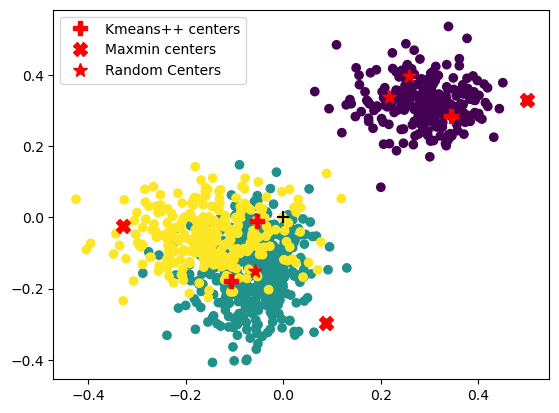

In [22]:
plt.scatter(centering(x_test[:,0]), centering(x_test[:,1]), c=y_test)
plt.scatter(cc_plus[:,0], cc_plus[:,1], c='red', marker='P', s = 100)
plt.scatter(cc_maximin[:,0], cc_maximin[:,1], c='red', marker='X', s=100)
plt.scatter(cc_random[:,0], cc_random[:,1], c='red', marker='*', s=100)
plt.scatter(0,0,c='black', marker='+', s=80)

l1 = mlines.Line2D([], [], color='red', marker='P', linestyle='None',
                          markersize=10, label='Kmeans++ centers')
l2 = mlines.Line2D([], [], color='red', marker='X', linestyle='None',
                          markersize=10, label='Maxmin centers')
l3 = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                          markersize=10, label='Random Centers')
plt.legend(handles=[l1, l2, l3])
plt.show()

#### Further work:

* Add stochastic version of MaxMin centers initialization

-------

### Random Swap algorithm

In [23]:
rs = RandomSwap(x)

In [24]:
%%time
labels, centers = rs.fit(k=5, 
                         max_convergence_iter=50, 
                         max_swaps=10,
                         init_centers=None, 
                         init_method='kmeans++')

CPU times: user 24.8 ms, sys: 290 µs, total: 25.1 ms
Wall time: 24.8 ms


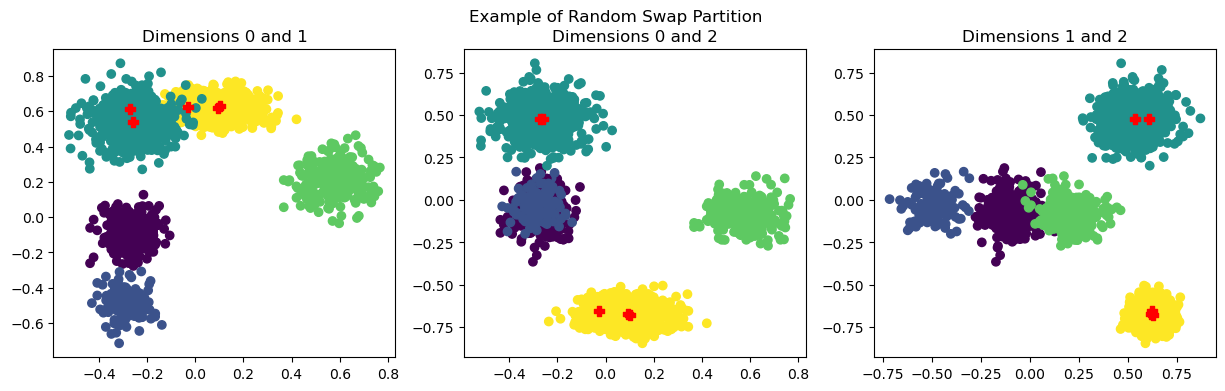

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
for p, (i,j) in enumerate(list(combinations(np.arange(0, 3), 2))):
    ax[p].scatter(x[:,i], x[:,j], c=labels)
    ax[p].set_title(f'Dimensions {i} and {j}')
    
    ax[p].scatter(centers[:, i], centers[:, j], marker='P', c = 'red', s=50)
    
fig.suptitle('Example of Random Swap Partition')
plt.show()

-----
Example how did it work

In [26]:
hard_rs = RandomSwap(data = hard_x)
_, _ = hard_rs.fit(k=7, 
                   max_convergence_iter=50, 
                   max_swaps=10,
                   init_centers=None, 
                   init_method='kmeans++', 
                   early_stop=False)


In [27]:
rs_example = 'rs_example.gif'

filenames = list()

for i in range(len(hard_rs.last_call_history)):
    c = hard_rs.last_call_history[i]
    ls = cdist(hard_x, c).argmin(axis = 1)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))
    plt.scatter(hard_x[:,0], hard_x[:,1], c=ls)
    plt.scatter(c[:,0], c[:,1], c='red', s = 60, marker='P')
    plt.scatter(true_centers[:,0], true_centers[:,1], s = 70, marker='o', facecolors='none', edgecolors='r')
    fig.suptitle(f'Iteration {i}')
    filename = f'km_ex_{i}.png'
    filenames.append(filename)
    plt.savefig(filename, dpi=100)
    plt.close()
    
with imageio.get_writer(rs_example, mode='I', duration=10/len(hard_rs.last_call_history)) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_406/2362909480.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


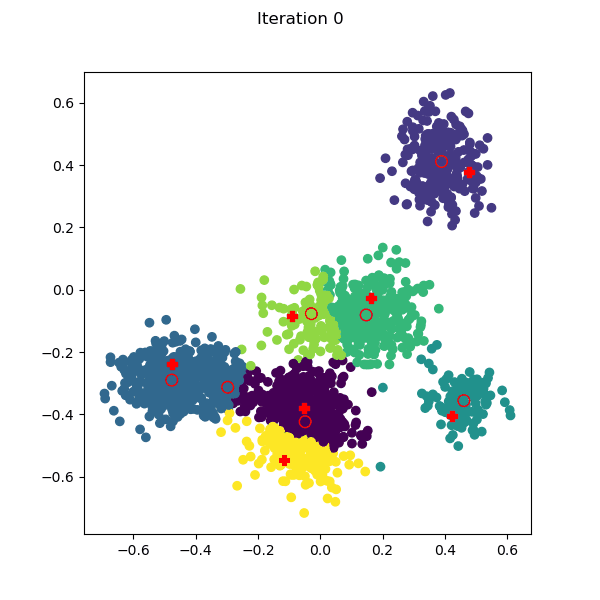

In [28]:
display.Image(rs_example)

<img src="pics/rs_example.gif" width="750" align="center">

-------

### Anomalous Patterns algorithm

In [29]:
ap = AnomalousPatterns(x)

Pay attention, that Anomalpus Patterns automatically centers the data as the algorithm depends on the location of points relatively to the center of coordinates (or gravity center).

In [30]:
%%time
labels, centers = ap.fit(max_iter=50)

CPU times: user 1.6 ms, sys: 75 µs, total: 1.67 ms
Wall time: 1.53 ms


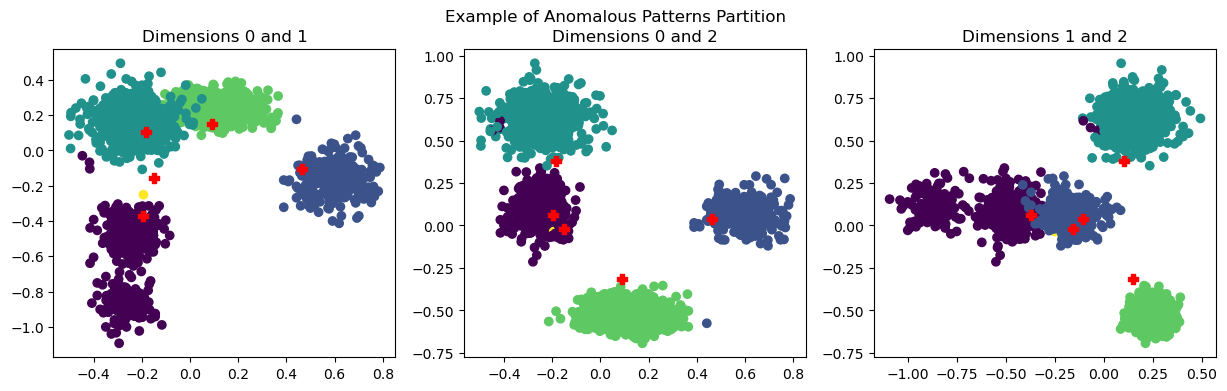

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
for p, (i,j) in enumerate(list(combinations(np.arange(0, 3), 2))):
    ax[p].scatter(centering(x[:,i]), centering(x[:,j]), c=labels)
    ax[p].set_title(f'Dimensions {i} and {j}')
    
    ax[p].scatter(centers[:, i], centers[:, j], marker='P', c = 'red', s=50)
    
fig.suptitle('Example of Anomalous Patterns Partition')
plt.show()

-----

In [32]:
hard_ap = AnomalousPatterns(data = hard_x)
ex_l, ex_c = hard_ap.fit(max_iter=50)


In [33]:
ap_example = 'ap_example.gif'

filenames = list()
actual_labels = np.zeros(hard_x.shape[0])

for i in range(len(hard_ap.last_call_history)):
    cls_num, cen = hard_ap.last_call_history[i][0]
    c = np.array([cen, np.zeros(cen.shape[0])])
    ls = cdist(centering(hard_x), c).argmin(axis = 1)
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))
    
    plt.scatter(centering(hard_x)[np.where(actual_labels != 1),0],
                centering(hard_x)[np.where(actual_labels != 1),1],
                c=ls[np.where(actual_labels != 1)])
    
    plt.scatter(centering(hard_x)[np.where(actual_labels == 1),0],
                centering(hard_x)[np.where(actual_labels == 1),1],
                c=ls[np.where(actual_labels == 1)],
                facecolors='none', edgecolors='none', s=0)
    
    plt.scatter(c[:,0], c[:,1], c='red', s = 60, marker='P')
    
    #plt.scatter(true_centers[:,0], true_centers[:,1], s = 70, marker='o', facecolors='none', edgecolors='r')
    fig.suptitle(f'Anomalous cluster {cls_num}: iteration {i}')
    filename = f'ap_ex_{i}.png'
    filenames.append(filename)
    plt.savefig(filename, dpi=100)
    plt.close()
    
    if (i < len(hard_ap.last_call_history) - 1):
        if (hard_ap.last_call_history[i+1][0][0] > hard_ap.last_call_history[i][0][0]):
            actual_labels[np.where(ls == 0)] = 1
    
with imageio.get_writer(ap_example, mode='I', duration=10/len(hard_ap.last_call_history)) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_406/3174650368.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


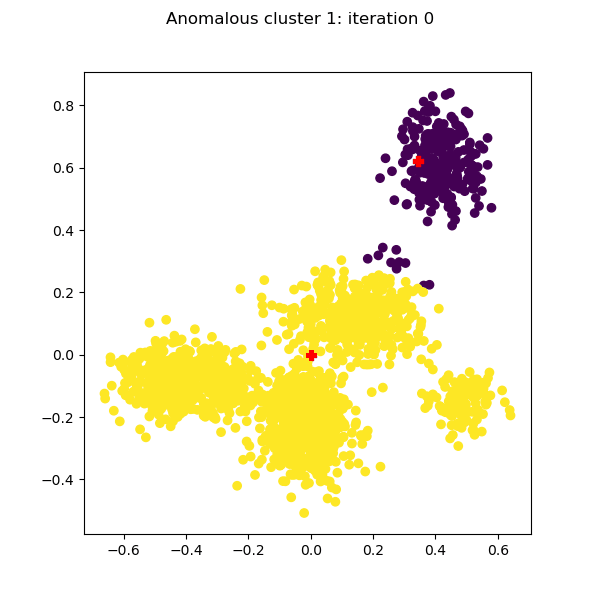

In [34]:
display.Image(ap_example)

<img src="pics/ap_example.gif" width="750" align="center">

#### Further work:

* Add stochastic version of center initialization as of now algorithm is fully deterministic
* Add extensive version that also depends on the density of extracted clusters
* Create methods to choose the number of clusters based on the extracted "anomalous" clusters